Original data shape: (6534, 14), Cleaned data shape: (4598, 14)
(3, 14)


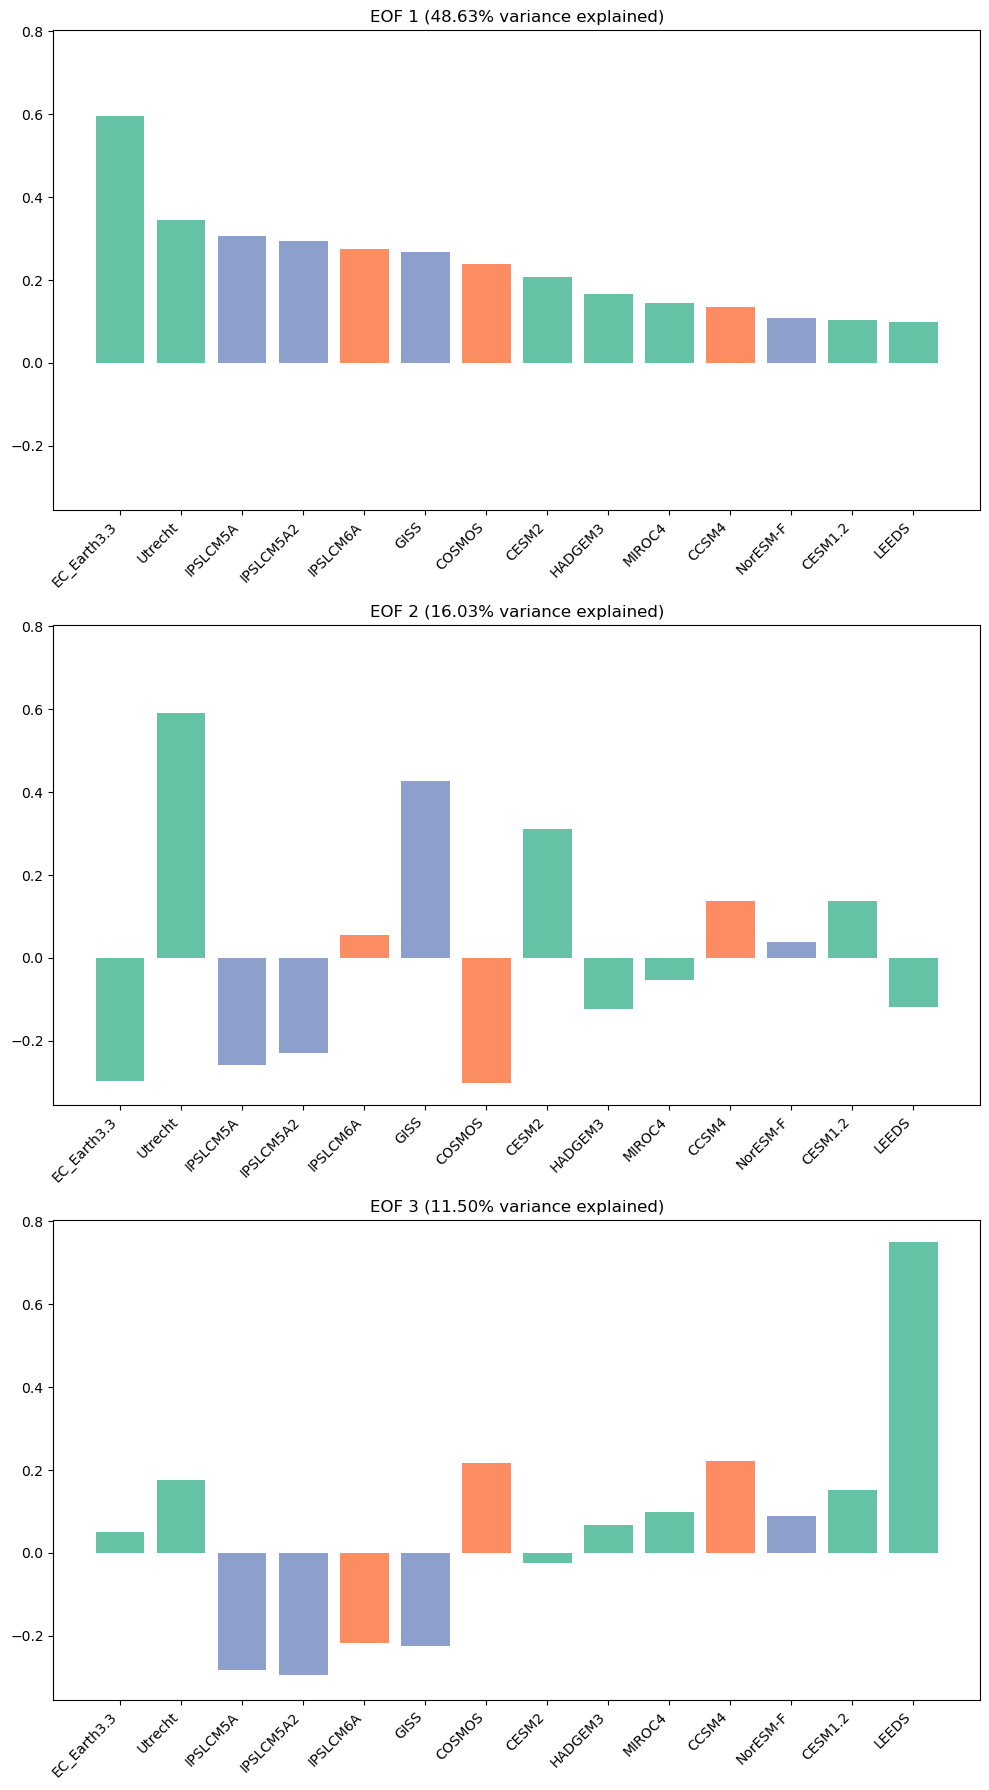

<Figure size 640x480 with 0 Axes>

In [2]:
import xarray as xr
import numpy as np 
import pandas as pd
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
suppress_warnings = True 
suppress_plots = False 
if suppress_warnings:
    warnings.filterwarnings("ignore")
if suppress_plots:
    import matplotlib
    matplotlib.use("Agg")

# Open dataset
ds = xr.open_dataset('/glade/u/home/nwrye/OceanTemps_Compiles/Latlev Anomaly Files/latlev_anom_models.nc')

# Extract models while dropping MMM and MCA
models_to_keep = [model for model in ds.data_vars if model not in ['MMM', 'MCA Late Plio', 'MCA Early Plio']]
data_matrix = np.array([ds[model].values.flatten() for model in models_to_keep]).T  # Shape: (num_points, num_models)

# Find and remove rows that contain NaNs
nan_mask = np.isnan(data_matrix).any(axis=1)
clean_data_matrix = data_matrix[~nan_mask]

print(f"Original data shape: {data_matrix.shape}, Cleaned data shape: {clean_data_matrix.shape}")

# Extract latitude values
latitudes = ds['lat'].values

# Compute latitude weights (sqrt of cosine of latitude)
lat_weights = np.sqrt(np.cos(np.radians(latitudes)))

# Expand weights to match the data structure
lat_weights_2d = np.tile(lat_weights[:, np.newaxis], (ds.sizes['lev'], 1))  
lat_weights_flat = lat_weights_2d.flatten()[~nan_mask]  # Flatten and apply NaN mask

# Apply latitude weighting to the data
weighted_data = clean_data_matrix * lat_weights_flat[:, np.newaxis]

# Perform PCA on weighted data
pca = PCA(n_components=3)
pca_result = pca.fit_transform(weighted_data)
EOFs = pca.components_  # Shape: (num_EOFs, num_models)
print(EOFs.shape)

# Convert EOFs back to xarray (use 'model' as a dimension)
eof_ds = xr.Dataset({
    f'EOF{i+1}': (['model'], EOFs[i])
    for i in range(EOFs.shape[0])
}, coords={'model': models_to_keep})

# Define number of EOFs to visualize
num_components = min(3, len(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Create figure with subplots
fig, axes = plt.subplots(num_components, 1, figsize=(10, 18), sharey=True)

# FIRST: Get the sorting order from EOF1
eof1_values = eof_ds['EOF1'].values
sorted_indices = np.argsort(eof1_values)[::-1]  # Descending order
sorted_models = np.array(models_to_keep)[sorted_indices]

# Define models to highlight and their colors
highlight_models = {
    'CESM2': '#66c2a5',
    'CESM1.2': '#66c2a5',
    'EC_Earth3.3': '#66c2a5',
    'HADGEM3_NEW_1997': '#66c2a5',
    'MIROC4_2004': '#66c2a5',
    'Utrecht_CESM1.0.5': '#66c2a5',
    'LEEDS': '#66c2a5',
    'CCSM4': '#fc8d62',
    'COSMOS': '#fc8d62',
    'IPSLCM6A_LR': '#fc8d62',
    'GISS': '#8da0cb',
    'NorESM-F': '#8da0cb',
    'IPSLCM5A': '#8da0cb',
    'IPSLCM5A2': '#8da0cb',
    
}

# Define model renames (only for the ones you want to change)
model_renames = {
    'Utrecht_CESM1.0.5': 'Utrecht',
    'HADGEM3_NEW_1997': 'HADGEM3',
    'IPSLCM6A_LR': 'IPSLCM6A',
    'MIROC4_2004' : 'MIROC4',
}

# Generate labels (only renames specified models)
renamed_models = [model_renames.get(model, model) for model in sorted_models]

# Plotting loop (now uses renamed_models for labels)
for i in range(num_components):
    ax = axes[i]
    sorted_eof_values = eof_ds[f'EOF{i+1}'].values[sorted_indices]
    colors = [highlight_models.get(model, 'steelblue') for model in sorted_models]  # Original names for colors
    
    # Plot with renamed labels
    ax.bar(renamed_models, sorted_eof_values, color=colors)
    ax.set_title(f'EOF {i+1} ({variance[i]:.2f}% variance explained)')
    ax.set_xticklabels(renamed_models, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/EOF_Decomp_LatitudeVSDepth.pdf', dpi=300, bbox_inches="tight")
plt.show()

fig.suptitle('EOF Decomposition (Latitude VS. Depth)', fontsize=16, fontweight='bold', y=1)

plt.tight_layout()
#plt.savefig('/glade/u/home/nwrye/OceanTemps_Compiles/EOF_Deconposition_LatitudeVSDepth.pdf', dpi=300, bbox_inches="tight")
plt.show()